In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
METRIC = "systemic_failure"

In [3]:
df = pd.read_csv("../data/german_credit_results/german_credit_results_conformal.csv")
CONFORMAL = True
N_TRAIN = 800
MIN_DATA_SCALE = int(N_TRAIN/2)
PARTITIONS_DATA_SCALE = int(N_TRAIN/5)
df["data_scale"] = (N_TRAIN/df["data_scale"]).astype(int)

In [4]:
df = df.drop(columns=["random_seed", "task_type"])
df = df.groupby(["exp_type", "random_distance", "num_models", "data_scale", "method"]).mean().reset_index(drop=False)

/var/folders/6w/yt_9nm1s5ngbsytz47vfxfjh0000gn/T/ipykernel_29566/3049963322.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(["exp_type", "random_distance", "num_models", "data_scale", "method"]).mean().reset_index(drop=False)


In [5]:
def table_by_models(data, metric, exp_type="baseline", method="lockout", data_scale=MIN_DATA_SCALE):
    df = data
    df = df[df["data_scale"]==MIN_DATA_SCALE]
    df = df[df["method"]==method]
    df = df[df["exp_type"]==exp_type]
    df = df[["num_models", "random_distance", metric]]
    df = df[df["num_models"]>1]
    rows = []
    for r in df["random_distance"].unique():
        row = {}
        row["random_distance"] = r
        for n in np.sort(df["num_models"].unique()):
            row[str(n)] = float(df.loc[(df["random_distance"]==r) & (df["num_models"]==n), metric])
        rows.append(row)
    return pd.DataFrame(rows).round(3)

In [6]:
def table_by_data(data, metric, exp_type="baseline", method="lockout", num_models=2):
    df = data
    df = df[df["num_models"]==num_models]
    df = df[df["method"]==method]
    df = df[df["exp_type"]==exp_type]
    df = df[["data_scale", "random_distance", metric]]
    rows = []
    for r in df["random_distance"].unique():
        row = {}
        row["random_distance"] = r
        for n in np.sort(df["data_scale"].unique()):
            row[str(n)] = float(df.loc[(df["random_distance"]==r) & (df["data_scale"]==n), metric])
        rows.append(row)
    return pd.DataFrame(rows).round(3)

In [7]:
def table_by_fairness(data, metrics):
    df = data
    df = df[df["method"]=="lockout"]
    df = df[df["exp_type"]=="baseline"]
    df = df[df["num_models"]==10]
    df = df[df["data_scale"]==MIN_DATA_SCALE]
    
    cols = ["random_distance"]
    for m in metrics:
        cols.append(m+"_0")
        cols.append(m+"_1")
    return df[cols].reset_index(drop=True).round(3)

In [8]:
def plot(data, metric, xaxis, exp_type="baseline", method="lockout", ylog=False, ylim=None, save=False):
    plt.rcParams["figure.figsize"] = [7,3]
    fig, ax = plt.subplots()

    df = data
    df = df[df["method"]==method]
    df = df[df["exp_type"]==exp_type]
    df = df[df[xaxis]>1]

    if CONFORMAL:
        plt.plot(df.loc[df["random_distance"]==0, xaxis], df.loc[df["random_distance"]==0, metric], '*-', color='green', label="Threshold")
        plt.plot(df.loc[df["random_distance"]==0.05, xaxis], df.loc[df["random_distance"]==0.05, metric], '*-', color='#001e49', label="Alpha = 0.05")
        plt.plot(df.loc[df["random_distance"]==0.1, xaxis], df.loc[df["random_distance"]==0.1, metric], '*-', color='#002f70', label="Alpha = 0.1")
        plt.plot(df.loc[df["random_distance"]==0.2, xaxis], df.loc[df["random_distance"]==0.2, metric], '*-', color='#003f97', label="Alpha = 0.2")
        plt.plot(df.loc[df["random_distance"]==0.3, xaxis], df.loc[df["random_distance"]==0.3, metric], '*-', color='#004fbf', label="Alpha = 0.3")
        plt.plot(df.loc[df["random_distance"]==0.4, xaxis], df.loc[df["random_distance"]==0.4, metric], '*-', color='#0068f9', label="Alpha = 0.4")
    else:
        plt.plot(df.loc[df["random_distance"]==0, xaxis], df.loc[df["random_distance"]==0, metric], '*-', color='green', label="Threshold")
        plt.plot(df.loc[df["random_distance"]==0.1, xaxis], df.loc[df["random_distance"]==0.1, metric], '*-', color='#001e49', label="Random(0.4,0.6)")
        plt.plot(df.loc[df["random_distance"]==0.2, xaxis], df.loc[df["random_distance"]==0.2, metric], '*-', color='#002f70', label="Random(0.3,0.7)")
        plt.plot(df.loc[df["random_distance"]==0.3, xaxis], df.loc[df["random_distance"]==0.3, metric], '*-', color='#003f97', label="Random(0.2,0.8)")
        plt.plot(df.loc[df["random_distance"]==0.4, xaxis], df.loc[df["random_distance"]==0.4, metric], '*-', color='#004fbf', label="Random(0.1,0.9)")
        plt.plot(df.loc[df["random_distance"]==0.5, xaxis], df.loc[df["random_distance"]==0.5, metric], '*-', color='#0068f9', label="All Random")


    if ylim:
        plt.ylim(ylim)
    if ylog:
        plt.yscale('log')   

    plt.xlabel(xaxis)
    plt.ylabel(metric)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    fig.tight_layout()
    fig.savefig(metric+'.png')
    plt.show()

In [9]:
def plot_fairness(data, metrics=[],labels=[], exp_type="baseline", method="lockout"):
    plt.rcParams["figure.figsize"] = [5.5,3]
    fig, ax = plt.subplots()

    df = data
    df = df[df["method"]==method]
    df = df[df["exp_type"]==exp_type]
    df = df[df["num_models"]==10]
    df = df[df["data_scale"]==MIN_DATA_SCALE]
    
    metric_lines = []
    class_lines = []
    colors = ["blue", "green", "red"]
    for i,m in enumerate(metrics):
        lin1, = plt.plot(df["random_distance"], df[m+"_0"], '*--', color=colors[i])
        lin2, = plt.plot(df["random_distance"], df[m+"_1"], '*-', color=colors[i])
        if i==0:
            class_lines.append(lin1)
            class_lines.append(lin2)
        metric_lines.append(lin2)
    
    if CONFORMAL:
        plt.xlabel("Significance Level (alpha) for Randomized Prediction")
    else:
        plt.xlabel("Distance from Threshold for Randomized Predictions")
        
    legend1 = plt.legend(class_lines, ["Minority Class", "Majority Class"], bbox_to_anchor=(1.05, 0.25), loc='upper left')
    plt.legend(metric_lines, labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.gca().add_artist(legend1)

In [10]:
def plot_tasks(data, metric, method="lockout", num_tasks=2):
    plt.rcParams["figure.figsize"] = [5,3]
    fig, ax = plt.subplots()

    df = data
    df = df[df["method"]==method]
    df = df[df["exp_type"]=="tasks"]
    df = df[df["data_scale"]==MIN_DATA_SCALE]
    df = df[df["num_models"]==num_tasks]

    plt.bar(np.array(df["random_distance"]), np.array(df[metric]), width=0.02)

    if CONFORMAL:
        plt.xlabel("Significance Level (alpha) for Randomized Prediction")
    else:
        plt.xlabel("Distance from Threshold for Randomized Predictions")
        
    plt.ylabel(metric)
    
    fig.tight_layout()
    plt.show()

# Results -- Accuracy

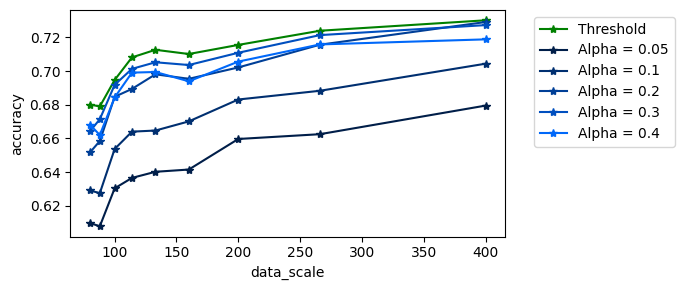

In [11]:
plot(df[df["num_models"]==10], "accuracy", "data_scale")

In [12]:
table_by_models(df, "accuracy")[["random_distance", "10"]].rename(columns={'10':"accuracy"})

,random_distance,accuracy
0,0.00,0.730
1,0.05,0.679
2,0.10,0.704
3,0.20,0.729
4,0.30,0.727
5,0.40,0.719


### Acceptance Rate

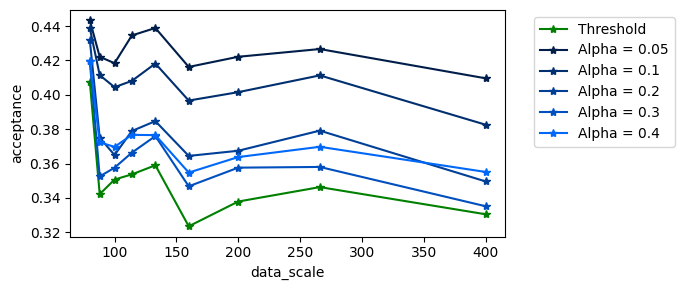

In [13]:
plot(df[df["num_models"]==10], "acceptance", "data_scale")

# Results -- Homogenization As Repeated Inaccurate Decisions

### Baseline: Homogenization Across Same Model Class + Training Data + Prediction Task

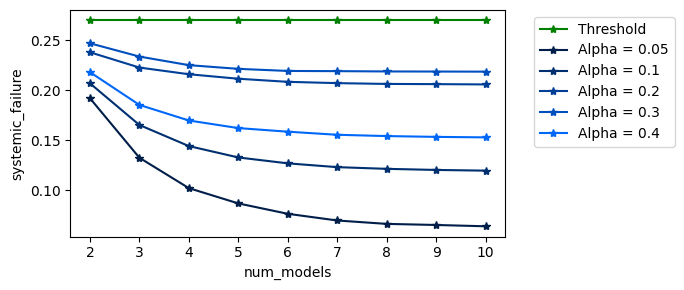

In [14]:
plot(df[df["data_scale"]==MIN_DATA_SCALE], METRIC, "num_models", "baseline", "inaccurate")

In [15]:
table_by_models(df, METRIC, "baseline", "inaccurate")

,random_distance,2,3,4,5,6,7,8,9,10
0,0.00,0.270,0.270,0.270,0.270,0.270,0.270,0.270,0.270,0.270
1,0.05,0.192,0.132,0.102,0.087,0.076,0.070,0.066,0.065,0.064
2,0.10,0.207,0.165,0.144,0.133,0.127,0.123,0.121,0.120,0.119
3,0.20,0.238,0.223,0.216,0.211,0.208,0.207,0.206,0.206,0.206
4,0.30,0.247,0.234,0.225,0.221,0.219,0.219,0.219,0.219,0.219
5,0.40,0.218,0.185,0.170,0.162,0.158,0.155,0.154,0.153,0.153


### Different Training Data (Same Model Class + Prediction Task)

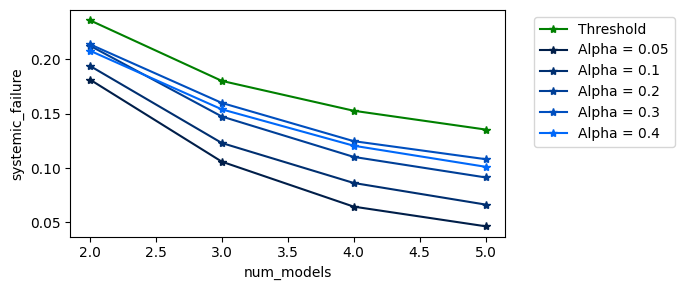

In [16]:
plot(df[df["data_scale"]==PARTITIONS_DATA_SCALE], METRIC, "num_models", "data_partitions", "inaccurate")

### Different Model Classes (Same Training Data + Prediction Task)

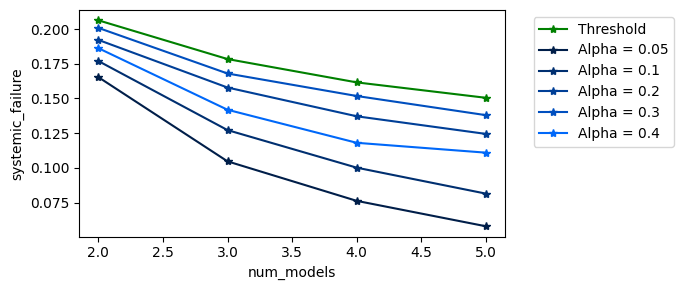

In [17]:
plot(df[df["data_scale"]==MIN_DATA_SCALE], METRIC, "num_models", "models", "inaccurate")

### Different Prediction Tasks (Same Model Class + Training Data)

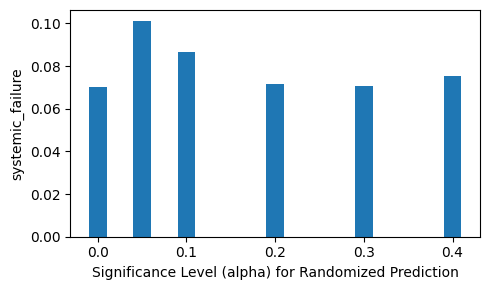

In [18]:
plot_tasks(df, METRIC, "inaccurate", 2)

# Results -- Homogenization As Repeated Negative Decisions

### Baseline: Homogenization Across Same Model Class + Training Data + Prediction Task

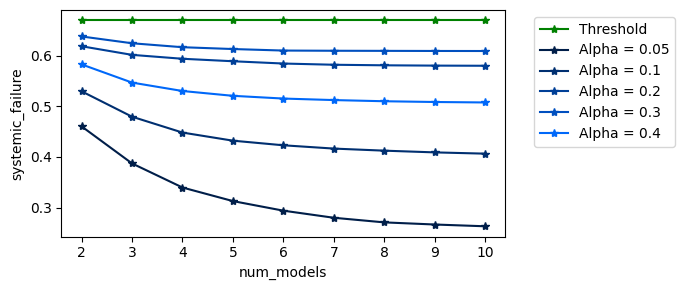

In [19]:
plot(df[df["data_scale"]==MIN_DATA_SCALE], METRIC, "num_models", "baseline", "lockout")

In [20]:
table_by_models(df, METRIC, "baseline", "lockout")

,random_distance,2,3,4,5,6,7,8,9,10
0,0.00,0.670,0.670,0.670,0.670,0.670,0.670,0.670,0.670,0.670
1,0.05,0.460,0.387,0.340,0.313,0.294,0.280,0.271,0.267,0.263
2,0.10,0.529,0.479,0.448,0.432,0.423,0.416,0.412,0.409,0.406
3,0.20,0.618,0.601,0.594,0.589,0.584,0.582,0.581,0.580,0.580
4,0.30,0.638,0.624,0.616,0.613,0.610,0.609,0.609,0.609,0.609
5,0.40,0.582,0.547,0.530,0.520,0.515,0.512,0.510,0.508,0.507


### Different Training Data (Same Model Class + Prediction Task)

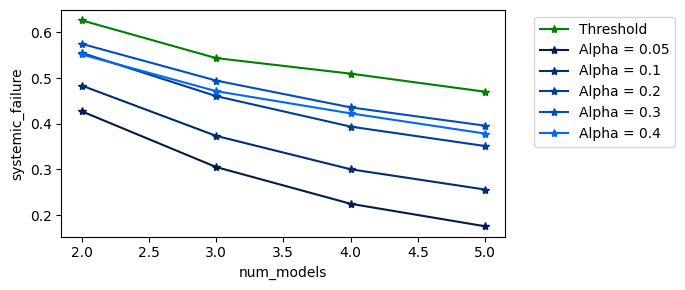

In [21]:
plot(df[df["data_scale"]==PARTITIONS_DATA_SCALE], METRIC, "num_models", "data_partitions", "lockout")

### Different Model Classes (Same Training Data + Prediction Task)

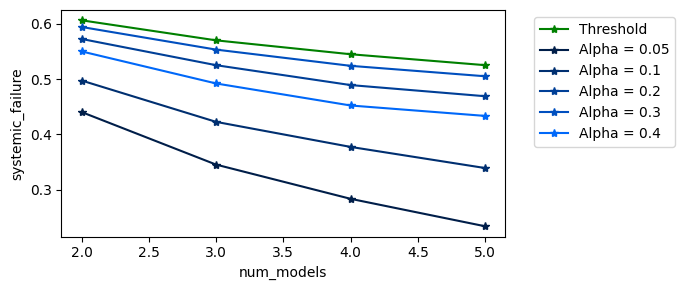

In [22]:
plot(df[df["data_scale"]==MIN_DATA_SCALE], METRIC, "num_models", "models", "lockout")

### Different Prediction Tasks (Same Model Class + Training Data)

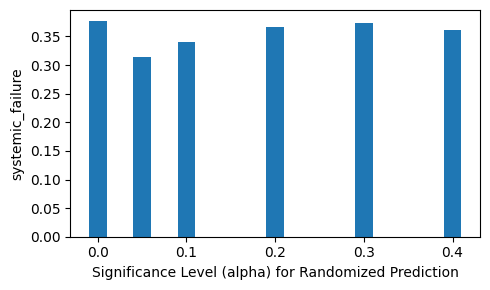

In [23]:
plot_tasks(df, METRIC, "lockout", 2)

# Results -- By Data Scale

### Homogenization As Repeated Inaccurate Decisions

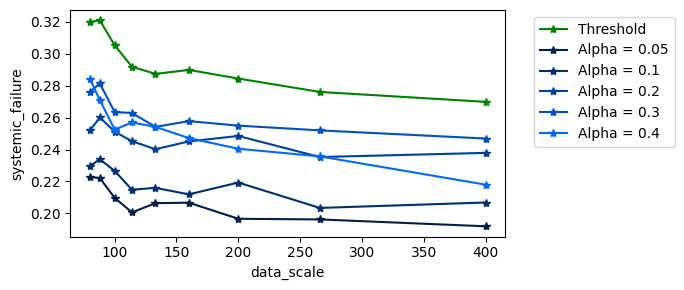

In [24]:
plot(df[df["num_models"]==2], METRIC, "data_scale", "baseline", "inaccurate")

### Homogenization As Repeated Negative Decisions

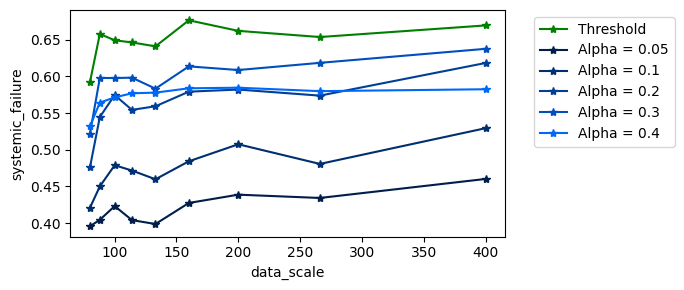

In [25]:
plot(df[df["num_models"]==2], METRIC, "data_scale", "baseline", "lockout")

# Results -- Group Fairness Metrics

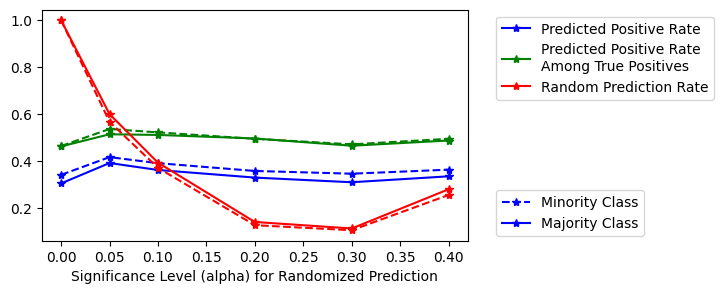

In [26]:
plot_fairness(df, ["pred_pos", "true_pos", "random"], ["Predicted Positive Rate",
                                    "Predicted Positive Rate\nAmong True Positives",
                                    "Random Prediction Rate"])

In [27]:
table_by_fairness(df, ["random", "pred_pos", "true_pos"])

,random_distance,random_0,random_1,pred_pos_0,pred_pos_1,true_pos_0,true_pos_1
0,0.00,1.000,1.000,0.342,0.306,0.465,0.463
1,0.05,0.568,0.600,0.418,0.393,0.537,0.515
2,0.10,0.372,0.394,0.392,0.363,0.523,0.512
3,0.20,0.128,0.142,0.359,0.331,0.496,0.497
4,0.30,0.107,0.114,0.347,0.311,0.472,0.466
5,0.40,0.257,0.281,0.364,0.336,0.496,0.488


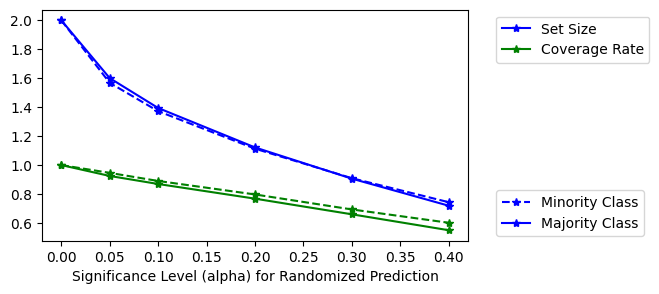

In [28]:
plot_fairness(df, ["conf_set_size", "conf_coverage"], ["Set Size", "Coverage Rate"])

In [29]:
table_by_fairness(df, ["random", "conf_set_size", "conf_coverage"])

,random_distance,random_0,random_1,conf_set_size_0,conf_set_size_1,conf_coverage_0,conf_coverage_1
0,0.00,1.000,1.000,2.000,2.000,1.000,1.000
1,0.05,0.568,0.600,1.568,1.600,0.946,0.925
2,0.10,0.372,0.394,1.372,1.394,0.890,0.869
3,0.20,0.128,0.142,1.113,1.122,0.797,0.768
4,0.30,0.107,0.114,0.909,0.906,0.693,0.660
5,0.40,0.257,0.281,0.743,0.719,0.601,0.550
